# Import everything

In [1]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from tqdm.notebook import tqdm
import math

import multiprocessing
from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from timeit import default_timer as timer
from datetime import timedelta
import json
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm
from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks, butter
from scipy.integrate import simps
from scipy.io import loadmat
from numpy import trapz
import scipy.fftpack

# Load file paths of EEGs.

In [2]:
root = ''
paths_raw = sorted(glob.glob(root + 'data/dataset3/raw/*.mat'))
paths_raw_hjorth = sorted(glob.glob(root + 'data/dataset3/raw-hjorth/*.mat'))
paths_clean = sorted(glob.glob(root + 'data/dataset3/clean/*.mat'))
paths_clean_hjorth = sorted(glob.glob(root + 'data/dataset3/clean-hjorth/*.mat'))
print("Raw: {}\nRaw Hjorth: {}\nClean: {}\nClean Hjorth: {}".format(len(paths_raw), len(paths_raw_hjorth), len(paths_clean), len(paths_clean_hjorth)))

Raw: 16
Raw Hjorth: 16
Clean: 16
Clean Hjorth: 16


# Read EEG files

In [3]:
def read_trials_from_raw(filename, time_start, time_end, columns):
    x = loadmat(filename)
    x = x['EEGData']
    trials = []
    time = np.linspace(time_start, time_end, len(x[0, :, 0]))
    for trial_num in range(x.shape[2]):
        trial = np.transpose(x[:, :, trial_num])
        trial = pd.DataFrame(data=trial, columns=columns)
        trial['time'] = time
        trials.append(trial)
    return trials

def read_trials_from_hjorth(filename, time_start, time_end):
    x = loadmat(filename)
    mat_trials = x['dat'][0][0][3][0]
    trials = []
    time = np.linspace(time_start, time_end, len(mat_trials[0][0]))
    for mat_trial in mat_trials:
        trials.append(pd.DataFrame({'C3': mat_trial[0], 'C4': mat_trial[1], 'time': time}))
    return trials

# Power and phase calculation

In [11]:
def blackman_harris_filter(channel, time, cutoffs, fs, numtaps):
    b = signal.firwin(numtaps, cutoffs, window='blackmanharris', fs=fs)
    filtered = signal.lfilter(b, 1, channel)
    delay = 0.5 * (numtaps - 1) / fs
    df = pd.DataFrame({
        'time': time-delay,
        'channel': filtered
    })
    return df

def butter_bandpass_filter(data, lowcut, highcut, fs, btype, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype=btype)
    y = signal.lfilter(b, a, data)
    return y

def get_phase(channel, time, band, fs, filter_type, start_time_ms, stop_time_ms, blackmann_harris_ntaps, line_noise_band):
    
    if line_noise_band is not None:
        if filter_type == 'butter':
            channel = butter_bandpass_filter(channel, line_noise_band[0], line_noise_band[1], fs, 'bandstop', order=4)
        else:
            df_filtered = blackman_harris_filter(channel, time, line_noise_band, fs, numtaps=blackmann_harris_ntaps)
            channel = df_filtered['channel'].values
            time = df_filtered['time'].values
    
    if filter_type=='butter':
        df_filtered = pd.DataFrame({'channel': butter_bandpass_filter(channel, band[0], band[1], fs, btype='bandpass', order=3), 'time': time})
    else:
        df_filtered = blackman_harris_filter(channel, time, [0.000001, band[0]], fs, numtaps=blackmann_harris_ntaps)
        df_filtered = blackman_harris_filter(df_filtered['channel'].values, df_filtered['time'].values, band[1], fs, numtaps=blackmann_harris_ntaps)    
    
    hilb = signal.hilbert(df_filtered[(df_filtered['time'] > start_time_ms) & (df_filtered['time'] < stop_time_ms)]['channel'])
    phase = np.angle(hilb, deg=True)
    df_phase = pd.DataFrame(phase, columns=['phase'])
    df_phase['time'] = df_filtered[(df_filtered['time'] > start_time_ms) & (df_filtered['time'] < stop_time_ms)]['time'].values
    return df_phase

def get_power(channel, time, fs, crop_start_millis, crop_end_millis, method, filter_type, resample_fs, line_noise_band, blackmann_harris_ntaps):
    # Crop.
    channel = channel[(time > crop_start_millis) & (time < crop_end_millis)].values
    time = time[(time > crop_start_millis) & (time < crop_end_millis)].values
    
    # Resample
    if resample_fs is None:
        resampled = channel
        resampled_time = time
    else:
        ts = time[1] - time[0]
        secs = len(channel) * ts
        secs = secs/1000
        resampled = signal.resample(channel, int(secs*resample_fs))
        resampled_time = np.linspace(time[0], time[-1], len(resampled))
        fs = resample_fs

    # Remove line nosie.
    if filter_type == 'butter':
        resampled = butter_bandpass_filter(resampled, line_noise_band[0], line_noise_band[1], fs, 'bandstop', order=4)
        resampled_time = time
    else:
        df_filtered = blackman_harris_filter(resampled, resampled_time, line_noise_band, fs, numtaps=blackmann_harris_ntaps)
        resampled = df_filtered['channel'].values
        resampled_time = df_filtered['time']
    
    # PSD.
    if method == 'welch':
        # Welch method
        # freq, power = signal.welch(resampled, fs, nperseg=4*fs, nfft=fs)
        freq, power = signal.welch(resampled, fs, nperseg=len(resampled), nfft=fs)
        df_power = pd.DataFrame({'freq': freq, 'power': power})
    elif method == 'fft':
        # FFT method
        T = 1/fs
        N = fs//2
        yf = scipy.fftpack.fft(resampled, n=N)
        yf = 2 / (N/2) * np.abs(yf[:N//2])
        xf = np.linspace(0, 1/(2*T), N // 2)
        df_power = pd.DataFrame({'freq': xf, 'power': yf})
    elif method == 'pburg':
        # Burgs method
        order = min(len(resampled)-2, int(fs/4))
        p = pburg(resampled, order, sampling=fs, NFFT=fs)
        power = p.psd
        freq = np.linspace(0, fs/2, len(power))
        df_power = pd.DataFrame({'freq': freq, 'power': power})

    df_power = df_power[df_power['freq'] < fs/2]
    df_power['power'] = 10 * np.log10(df_power['power'])
    return df_power

# Diagnose #1

In [12]:
# ind = 5
# trial_num = 20
# print("{} - {}".format(ind, paths_raw[ind]))

# trials = read_trials_from_raw(paths_raw[ind], -900, 0, ['FP1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'IZ', 'OZ', 'POZ', 'PZ', 'CPZ', 'FPZ', 'FP2', 'AF8', 'AF4', 'AFZ', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCZ', 'CZ', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'M1', 'M2', 'NAS', 'LVEOG', 'RVEOG', 'LHEOG', 'RHEOG', 'NFPZ'])
# # trials = read_trials_from_raw(clean_files[ind], -900, 0, ['AF1', 'AF2', 'AF7', 'AF8', 'AFZ', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPZ', 'CZ', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'FCZ', 'FP1', 'FP2', 'FPZ', 'FT7', 'FT8', 'FZ', 'O1', 'O2', 'OZ', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO1', 'PO2', 'PO7', 'PO8', 'POZ', 'PZ', 'T7', 'T8', 'TP7', 'TP8', 'X', 'Y', 'nd'])
# df_trial = trials[trial_num]

# time_start = -750
# df_trial = df_trial[df_trial['time'] > time_start]
# df_trial = df_trial[df_trial['time'] < 0]
# channel = df_trial['C3']
# time = df_trial['time']

# fs = 256
# band = [8, 12]
# blackmann_harris_ntaps = 101
# line_noise_band = [48, 52]


# i = 0
# f, axs = plt.subplots(1,3,figsize=(16,2))
# axs[i].plot(time, channel)
# axs[i].set_title('Waveform')
# i = i + 1

# freq, power = signal.welch(channel, fs, nperseg=4*fs, nfft=fs)
# df_power = pd.DataFrame({'freq': freq, 'power': power})
# df_power = df_power[df_power['freq'] < 80]
# axs[i].plot(df_power['freq'], 10 * np.log10(df_power['power']))
# axs[i].set_title('PSD - Welch')
# i = i + 1

# order = min(len(channel)-2, int(fs/4))
# p = pburg(channel, 64, sampling=fs, NFFT=fs)
# power = p.psd
# freq = np.linspace(0, fs/2, len(power))
# df_power = pd.DataFrame({'freq': freq, 'power': power})
# df_power = df_power[df_power['freq'] < 80]
# df_power = df_power[df_power['freq'] >3]
# axs[i].plot(df_power['freq'], 10 * np.log10(df_power['power']))
# axs[i].set_title('PSD - Burg')
# i = i + 1
# print(order)

# Diagnose #2

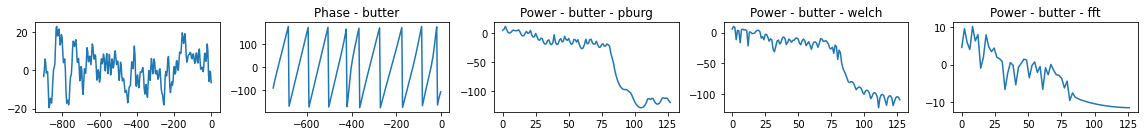

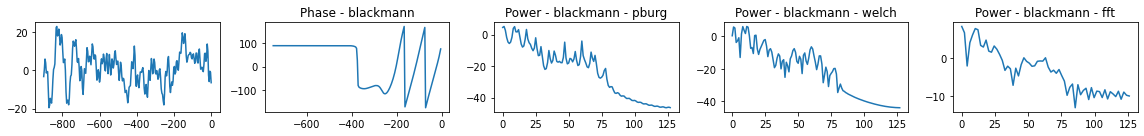

In [13]:
ind = 5
trials = read_trials_from_raw(paths_raw[ind], -900, 0, [
    'FP1', 'F3', 'F7', 'FT7', 'FC3', 'C3', 'T7', 'TP7', 'CP3', 'P3', 'P7', 'O1', 'OZ', 'PZ', 'CPZ', 'FP2', 'FZ', 'F4', 'F8', 'FT8', 'FC4', 'FCZ', 'CZ', 'C4', 'T8', 'TP8', 'CP4', 'P4', 'P8', 'O2'
])
trial = trials[20]
time = trial['time']
channel = trial['C3']

fs = 256
band = [8, 12]
blackmann_harris_ntaps = 151
line_noise_band = [58, 62]
crop_start_millis = -750

for filter_type in ['butter', 'blackmann']:
    i = 0
    f, axs = plt.subplots(1,5,figsize=(16,2))
    axs[i].plot(time, channel)
    i = i + 1
    
    df_phase = get_phase(channel, time, band=band, fs=fs, filter_type=filter_type, start_time_ms=-750, stop_time_ms=-1, blackmann_harris_ntaps=blackmann_harris_ntaps, line_noise_band=[58, 62])
    axs[i].plot(df_phase['time'], df_phase['phase'])
    axs[i].set_title("Phase - {}".format(filter_type))
    i = i + 1
    
    for method in ['pburg', 'welch', 'fft']:
        df_power = get_power(channel, time, fs, crop_start_millis=crop_start_millis, crop_end_millis=-1, method=method, filter_type=filter_type, resample_fs=None, line_noise_band=line_noise_band, blackmann_harris_ntaps=blackmann_harris_ntaps)
        df_power = df_power[df_power['freq'] < 130]
        axs[i].plot(df_power['freq'], df_power['power'])
        axs[i].set_title("Power - {} - {}".format(filter_type, method))
        i = i + 1
    plt.tight_layout()
    plt.show()

# Process trials

In [14]:
def process_trials(raw_path, raw_hjorth_path, clean_raw_path, clean_raw_hjorth_path):
    df_powers = []
    df_phases = []
    sub = raw_path.split('/')[-1].split('.')[0].split('_')[-1]
    trials_raw = read_trials_from_raw(raw_path, -1000, 0, [
        'FP1', 'F3', 'F7', 'FT7', 'FC3', 'C3', 'T7', 'TP7', 'CP3', 'P3', 'P7', 'O1', 'OZ', 'PZ', 'CPZ', 'FP2', 'FZ', 'F4', 'F8', 'FT8', 'FC4', 'FCZ', 'CZ', 'C4', 'T8', 'TP8', 'CP4', 'P4', 'P8', 'O2'
    ])
    trials_raw_hjorth = read_trials_from_hjorth(raw_hjorth_path, -1000, 0)
    trials_clean = read_trials_from_raw(clean_raw_path, -1000, 0, [
        'FP1', 'F3', 'F7', 'FT7', 'FC3', 'C3', 'T7', 'TP7', 'CP3', 'P3', 'P7', 'O1', 'OZ', 'PZ', 'CPZ', 'FP2', 'FZ', 'F4', 'F8', 'FT8', 'FC4', 'FCZ', 'CZ', 'C4', 'T8', 'TP8', 'CP4', 'P4', 'P8', 'O2'
    ])
    trials_clean_hjorth = read_trials_from_hjorth(clean_raw_hjorth_path, -1000, 0)
    
    for trial_num in range(len(trials_raw)):
        trial_raw = trials_raw[trial_num]
        trial_raw_hjorth = trials_raw_hjorth[trial_num]
        trial_clean = trials_clean[trial_num]
        trial_clean_hjorth = trials_clean_hjorth[trial_num]
        trial_clean_avg = trial_clean.copy()
        avg_channels = ['FT7', 'FC3', 'FCZ', 'T7', 'C3', 'CZ', 'TP7', 'CP3', 'CPZ']
        trial_clean_avg['C3'] = trial_clean_avg[avg_channels].mean(axis=1)
        trial_raw_avg = trial_raw.copy()
        trial_raw_avg['C3'] = trial_raw_avg[avg_channels].mean(axis=1)
        
        for eeg_type, artifact_removed, df_trial in zip(['Raw', 'Hjorth', 'Raw', 'Hjorth', 'Average', 'Average'], [False, False, True, True, True, False], [trial_raw, trial_raw_hjorth, trial_clean, trial_clean_hjorth, trial_clean_avg, trial_raw_avg]):
            for filter_code, filter_name in zip(['butter', 'blackmannharris'], ['Butterworth', 'Blackmann-Harris']):
                for time, ntaps in zip([-750, -250], [151, 51]):
                    for method_code, method_name in zip(['pburg', 'welch', 'fft'], ['Burg', 'Welch', 'FFT']):

                        try:
                            df_power = get_power(df_trial['C3'], df_trial['time'], fs=256, crop_start_millis=time, crop_end_millis=-1, method=method_code, filter_type=filter_code, resample_fs=None, line_noise_band=[58, 62], blackmann_harris_ntaps=ntaps)
                        except:
                            continue

                        for band, fc1, fc2 in zip(['Theta', 'Mu', 'Beta', 'Gamma'], [4, 8, 13, 30], [8, 12, 30, 80]):
                            power = df_power[df_power['freq'] >= fc1]
                            power = power[power['freq'] < fc2]
                            power = power['power'].mean(axis=0)
                            row = dict()
                            row['sub'] = sub
                            row['ArtifactRemoved'] = artifact_removed
                            row['EEG'] = eeg_type
                            row['Filter'] = filter_name
                            row['Time'] = time
                            row['Method'] = method_name
                            row['Band'] = band
                            row['Power'] = power
                            row['trial'] = trial_num
                            df_powers.append(row)
                for band, fc1, fc2 in zip(['Theta', 'Mu', 'Beta', 'Gamma'], [4, 8, 13, 30], [8, 12, 30, 80]):
                    phase = get_phase(df_trial['C3'], df_trial['time'], [fc1, fc2], filter_type=filter_code, start_time_ms=-750, stop_time_ms=-1, fs=256, blackmann_harris_ntaps=151, line_noise_band=[58, 62])
                    phase = phase.iloc[-1]['phase'] + 180
                    row = dict()
                    row['sub'] = sub
                    row['ArtifactRemoved'] = artifact_removed
                    row['EEG'] = eeg_type
                    row['Filter'] = filter_name
                    row['Band'] = band
                    row['Phase'] = phase
                    row['trial'] = trial_num
                    df_phases.append(row)
    return (df_powers, df_phases)

In [17]:
paths = [list(a) for a in zip(paths_raw, paths_raw_hjorth, paths_clean, paths_clean_hjorth)]
# num_cores = multiprocessing.cpu_count() - 2
# results = Parallel(n_jobs=num_cores)(delayed(process_trials)(path_raw, path_raw_hjorth, path_clean, path_clean_hjorth) for path_raw, path_raw_hjorth, path_clean, path_clean_hjorth in tqdm(paths, total=len(paths)))

results = []
for path_raw, path_raw_hjorth, path_clean, path_clean_hjorth in tqdm(paths, total=len(paths)):
    results.append(process_trials(path_raw, path_raw_hjorth, path_clean, path_clean_hjorth))

In [18]:
df_powers = []
df_phases = []
for powers, phases in tqdm(results):
    for power in powers:
        df_powers.append(power)
    for phase in phases:
        df_phases.append(phase)
df_powers = pd.DataFrame(df_powers)
df_phases = pd.DataFrame(df_phases)

In [19]:
df_powers.to_csv('166-d3-powers-v3.csv')
df_phases.to_csv('166-d3-phases-v3.csv')